In [2]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

In [3]:
# Check if the GPU is available
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [4]:
# Directory where images are stored without being separated by folders
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [5]:
#load image, resize, normalise and convert 
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)
        return np.array(image) / 255.0  # Normaliza a imagem para a faixa [0, 1]
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [6]:
# Path to the file IDs of the images with dark backgrounds
ids_dark = r'C:\Users\bruna\OneDrive - Universidade do Minho\Microbialdataset\dark_images_ids.txt'

# Load training group IDs from a text file
with open(ids_dark, 'r') as file:
    ids = [line.strip() for line in file.readlines()]

In [7]:
#number of ids loaded 
print(f"Número de IDs carregados: {len(ids)}")
print(f"Primeiros 5 IDs: {ids[:5]}")

Número de IDs carregados: 9649
Primeiros 5 IDs: ['10000', '10001', '10002', '10003', '10004']


In [8]:
# Split the IDs into training and validation (e.g. 80 per cent for training and 20 per cent for validation)
split_index = int(len(ids) * 0.8)
train_ids = ids[:split_index]
val_ids = ids[split_index:]

In [9]:
%%capture
# Lists for storing image paths and corresponding labels
train_data = []
val_data = []

# Iterar sobre todos os arquivos no diretório
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue

        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue

        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue

        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [10]:
#number of images loaded in training and validation
print(f"Número de imagens no conjunto de treinamento: {len(train_data)}")
print(f"Número de imagens no conjunto de validação: {len(val_data)}")

Número de imagens no conjunto de treinamento: 7718
Número de imagens no conjunto de validação: 1930


In [11]:
# Separar caminhos de imagem e rótulos para treinamento e validação
train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)

In [12]:
# Separate image paths and labels for training and validation
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Turn labels into one-hot encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))


In [14]:
# Create personalised data generator
class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, target_size=(112, 112)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.image_paths))
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [load_image(self.image_paths[i], self.target_size) for i in batch_indices]
        batch_labels = self.labels[batch_indices]
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [15]:
# Create training and validation generators
train_generator = DataGenerator(train_images, train_labels_one_hot, batch_size=32)
val_generator = DataGenerator(val_images, val_labels_one_hot, batch_size=32)

In [16]:
# Load the ResNet50 base model with pre-trained weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

In [17]:
# Freeze ResNet50 layers to train only customised layers
base_model.trainable = False

In [18]:
# Add new layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [19]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
# Fine-tuning 
# Defrost the last layers of ResNet50 for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [21]:
# Recompile the template
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [78]:
# Train the model with fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
242/242 [==============================] - 2410s 10s/step - loss: 1.4234 - accuracy: 0.3951 - val_loss: 1.5614 - val_accuracy: 0.3870
Epoch 2/10
242/242 [==============================] - 2825s 12s/step - loss: 1.3116 - accuracy: 0.4399 - val_loss: 1.3034 - val_accuracy: 0.4373
Epoch 3/10
242/242 [==============================] - 3629s 15s/step - loss: 1.2769 - accuracy: 0.4671 - val_loss: 1.2379 - val_accuracy: 0.4705
Epoch 4/10
242/242 [==============================] - 1990s 8s/step - loss: 1.2420 - accuracy: 0.4765 - val_loss: 1.6177 - val_accuracy: 0.3876
Epoch 5/10
242/242 [==============================] - 1982s 8s/step - loss: 1.2076 - accuracy: 0.4970 - val_loss: 1.6120 - val_accuracy: 0.3834
Epoch 6/10
242/242 [==============================] - 1973s 8s/step - loss: 1.1911 - accuracy: 0.5088 - val_loss: 1.4078 - val_accuracy: 0.3653
Epoch 7/10
242/242 [==============================] - 1981s 8s/step - loss: 1.1672 - accuracy: 0.5222 - val_loss: 1.5764 - val_accura

In [79]:
#save the modle
model.save('trained_model.resnet_dark')

INFO:tensorflow:Assets written to: trained_model.resnet_dark\assets


INFO:tensorflow:Assets written to: trained_model.resnet_dark\assets


In [80]:
# Evaluate the model using the validation data generator
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Loss on validation set: {val_loss}")
print(f"Accuracy on validation set: {val_accuracy}")

61/61 [==============================] - 404s 7s/step - loss: 1.1447 - accuracy: 0.5192
Loss on validation set: 1.144667148590088
Accuracy on validation set: 0.5191709995269775


In [81]:
from sklearn.metrics import confusion_matrix, classification_report

# Load and process the validation images
val_images_processed = np.array([load_image(img_path) for img_path in val_images])

# Check if any images haven't loaded correctly
val_images_processed = np.array([img for img in val_images_processed if img is not None])

# Get predictions from the model
val_predictions = model.predict(val_images_processed)

# Convert one-hot encoded predictions to labels
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

#confusion matrix
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Classification report
target_names = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4']
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

61/61 [==============================] - 43s 668ms/step
Matriz de Confusão:
[[197  13  46 208   4]
 [ 61  86  15 152   5]
 [ 21   8 241  85   5]
 [  6   5  67 287   0]
 [ 16  22  86 103 191]]
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.65      0.42      0.51       468
    Classe 1       0.64      0.27      0.38       319
    Classe 2       0.53      0.67      0.59       360
    Classe 3       0.34      0.79      0.48       365
    Classe 4       0.93      0.46      0.61       418

    accuracy                           0.52      1930
   macro avg       0.62      0.52      0.51      1930
weighted avg       0.63      0.52      0.52      1930



In [82]:
# Save the confusion matrix and the classification report
np.save('confusion_matrix.npy', conf_matrix)

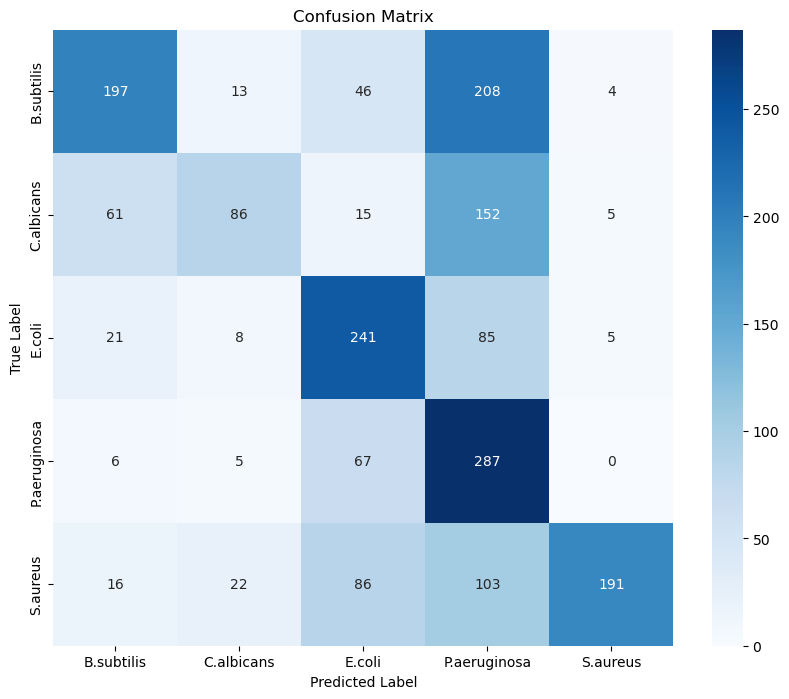

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualise the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('trained_model.resnet_dark')

# Load and process the validation images (if you haven't saved the predictions)
val_images_processed = np.array([load_image(img_path) for img_path in val_images])

# Get predictions from the model
val_predictions = model.predict(val_images_processed)

# Convert one-hot encoded predictions to probabilities
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)
val_predictions_probs = np.max(val_predictions, axis=1) 

61/61 [==============================] - 38s 603ms/step


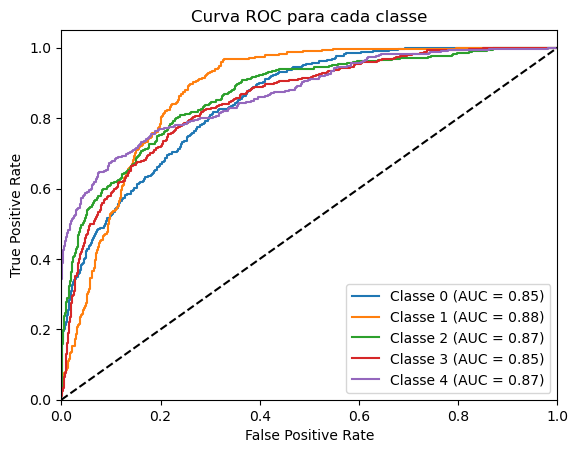

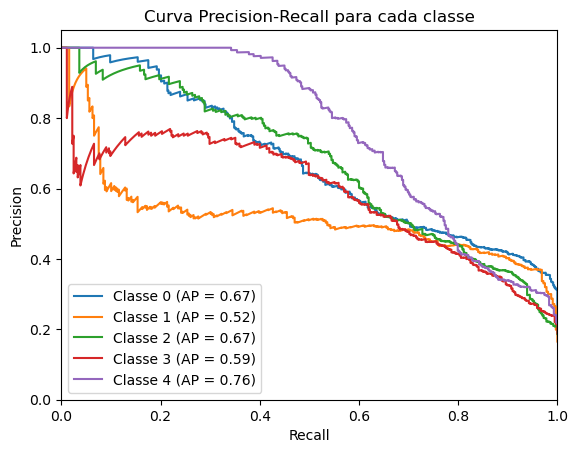

In [26]:
# ROC Curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(val_labels_one_hot[:, i], val_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Classe {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para cada classe')
plt.legend(loc="lower right")
plt.show()

# PRC curve with AP (Average Precision)
precision = {}
recall = {}
average_precision = {}

for i in range(len(label_encoder.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(val_labels_one_hot[:, i], val_predictions[:, i])
    average_precision[i] = average_precision_score(val_labels_one_hot[:, i], val_predictions[:, i])

# Plot the PRC curve for each class showing the AP value instead of AUC
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(recall[i], precision[i], label=f"Classe {i} (AP = {average_precision[i]:.2f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall para cada classe')
plt.legend(loc="lower left")
plt.show()